Importing the Python packages 

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
from sklearn import model_selection
from sklearn import feature_extraction
from sklearn import linear_model
from sklearn import svm
from sklearn import neighbors
from sklearn import metrics

In [3]:
from warnings import filterwarnings
filterwarnings('ignore')

## Loading dataset

Loading the pre-prepared dataset of disordered and ordered protein regions using the <code>pandas</code> package. Function <code>read_csv</code> reads from file in CSV (Comma-Separated Values) format and stores the data into the <code>DataFrame</code> object. <code>DataFrame</code> is a <code>pandas</code> 2-dimensional data structure that is used for storing tabular data, i.e. data that is organized in a table with rows and columns.

In [4]:
data = pd.read_csv('data/DisProt_PDB_dataset.csv')

In [5]:
data.head()

,ID,sequence,class
0,DP00003r002,EHVIEMDVTSENGQRALKEQSSKAKIVKNRWGRNVVQISNT,disorder
1,DP00003r004,VYRNSRAQGGG,disorder
2,DP00004r001,LLGDFFRKSKEKIGKEFKRIVQRIKDFLRNLVPRTES,disorder
3,DP00005r017,MDAQTRRRERRAEKQAQWKAANPLLVGVSAKPVNRPILSLNRKPKS...,disorder
4,DP00006r014,GDVEKGKKIFVQKCAQCHTVEKGGKHKTGPNLHGLFGRKTGQAPGF...,disorder


Setting column <code>'ID'</code> as the index of the <code>DataFrame</code> object.

In [6]:
data.set_index("ID", inplace=True)

In [7]:
data.head()

,sequence,class
ID,,
DP00003r002,EHVIEMDVTSENGQRALKEQSSKAKIVKNRWGRNVVQISNT,disorder
DP00003r004,VYRNSRAQGGG,disorder
DP00004r001,LLGDFFRKSKEKIGKEFKRIVQRIKDFLRNLVPRTES,disorder
DP00005r017,MDAQTRRRERRAEKQAQWKAANPLLVGVSAKPVNRPILSLNRKPKS...,disorder
DP00006r014,GDVEKGKKIFVQKCAQCHTVEKGGKHKTGPNLHGLFGRKTGQAPGF...,disorder


## Dataset analysis

Dimensions of the <code>DataFrame</code> object, i.e. the size of our dataset.

In [8]:
data.shape

(12743, 2)

Class distribution

In [9]:
data['class'].value_counts()

order       8511
disorder    4232
Name: class, dtype: int64

Distribution of sequence lengths by classes

In [10]:
data[data['class'] == 'order']['sequence'].apply(lambda x : len(x))

ID
DP00024r031      40
DP00030r011      18
DP00030r012      20
DP00030r013      13
DP00073r010      27
               ... 
7BY3B           127
1K32A          1045
2ZKZA            99
3RNVA           158
1SGMA           191
Name: sequence, Length: 8511, dtype: int64

<AxesSubplot:ylabel='Frequency'>

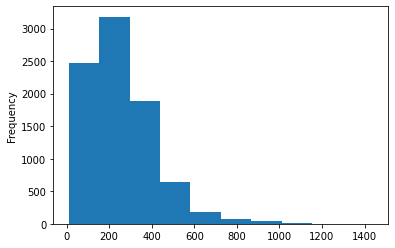

In [11]:
data[data['class'] == 'order']['sequence'].apply(lambda x : len(x)).plot.hist()

In [12]:
data[data['class'] == 'disorder']['sequence'].apply(lambda x : len(x))

ID
DP00003r002      41
DP00003r004      11
DP00004r001      37
DP00005r017     107
DP00006r014     104
               ... 
DP03902r001    1259
DP03903r001      41
DP03910r001      10
DP03910r002      21
DP03911r001      10
Name: sequence, Length: 4232, dtype: int64

<AxesSubplot:ylabel='Frequency'>

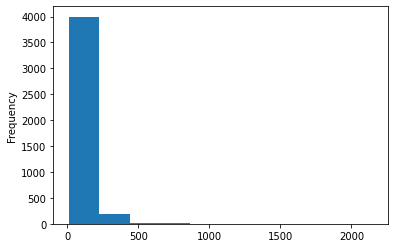

In [13]:
data[data['class'] == 'disorder']['sequence'].apply(lambda x : len(x)).plot.hist()

## Splitting dataset into a training and test subsets

Dataset is splitted into a training and test subsets in ratio 2:1. The splitting of the dataset is done using the stratification technique (parameter <code>stratify</code>) that preserves the same proportions of instances in each class as observed in the original dataset. The value of the parameter <code>random_state</code> is fixed in order to make reproducible train-test split.

In [14]:
x = data['sequence']
y = data['class']

In [15]:
x_train, x_test, y_train, y_test = model_selection.train_test_split(x, y, test_size=0.33, stratify=y, random_state=7)

In [16]:
len(x_train)

8537

In [17]:
len(x_test)

4206

# N-gram sequence representation

Knowing that certain aminoacids and their combinations are more likely (i.e. frequent) in ordered than disordered protein regions<a name="cite_ref-1"></a>[<sup>[1]</sup>](#cite_note-1), n-gram representation of protein sequences come as a natural choice. Based on the n-gram composition, different representations of protein sequences, suitable for machine learning models, can be constructed. Two basic methods, inherited from the field of Natural Language Processing, are:
- *Bag of Words* or *Bag of n-grams* method
- *TF-IDF* (Term Frequency - Inverse Document Frequency) method 

We can easily generate these two types of n-gram-based sequence representatin using the <code>feature_extraction</code> module (<code>text</code> submodule) from <code>sklearn</code> package.

<a name="cite_note-1"></a>[<sup>[1]</sup>](#cite_ref-1)Hydrophobic amino acids, more precisely clusters of hydrophobic amino acids are characteristical for ordered regions of proteins, while the hydrophylic aminoacids are more prevelent in disordered regions.

## Bag of Words representations

Firstly we well try with Bag of Words representations and train several types of classification models. Scikit-learn library provides support for n-gram sequence representation using the *Bag of Words method*  through the <code>CountVectorizer</code> class. Constructor function has various settings, mainly related to the preprocessing phase:
- <code>analyzer</code> - whether to tokenize text by the words or individual characters 
- <code>ngram_range</code> - the lower and upper boundary of the range of char n-grams to be extracted, only applies if analyzer is set to 'char'; e.g. an n-gram range of (1, 3) means that only unigrams, bigrams and trigrams will be extracted
- <code>min_df</code> - lower cutoff value of the frequency values, used for excluding tokens that have a frequency less than a given threshold 
- <code>max_df</code> - upper cutoff value of the frequency values, used for excluding tokens that have a frequency higher than a given threshold 
- <code>lowercase</code> - converting all characters to lowercase before tokenizing
- <code>stop_words</code> - excluding common words or words that are considered irrelevant for the specific problem
- <code>token_pattern</code> - excluding words that do not match a predefined format 
- <code>tokenizer</code> i <code>preprocessor</code> - passing a custom function to perform tokenization/preprocessing 
- <code>vocabulary</code> - assigning a pre-prepared vocabulary

We will set only the parameters <code>analyzer</code>, <code>ngram_range</code> and <code>min_df</code>, while default values will be taken for other parameters. We want to split text (protein sequences) by individual characters while extracting only the unigrams, bigrams and trigrams. Also we will want to exclude n-grams that appear less than 5 times.

In [18]:
count_vectorizer = feature_extraction.text.CountVectorizer(analyzer='char', ngram_range=(1, 3), min_df=5)

Vocabulary<a name="cite_ref-2"></a>[<sup>[2]</sup>](#cite_note-2), by rule, built over a training set. Later, while obtaining vector representations for test set instances, all unknown tokens (n-grams that are not present in the vocabulary) will be ignored.

<a name="cite_note-2"></a>[<sup>[2]</sup>](#cite_ref-2)Set of features (words or in our case n-grams) which will be used for sequence representations.

In [19]:
count_vectorizer.fit(x_train)

CountVectorizer(analyzer='char', min_df=5, ngram_range=(1, 3))

A list of extracted features (n-grams) can be obtained by method <code>get_feature_names()</code>.

In [20]:
feature_names = count_vectorizer.get_feature_names()
feature_names

['a',
 'aa',
 'aaa',
 'aac',
 'aad',
 'aae',
 'aaf',
 'aag',
 'aah',
 'aai',
 'aak',
 'aal',
 'aam',
 'aan',
 'aap',
 'aaq',
 'aar',
 'aas',
 'aat',
 'aav',
 'aaw',
 'aay',
 'ac',
 'aca',
 'acc',
 'acd',
 'ace',
 'acf',
 'acg',
 'ach',
 'aci',
 'ack',
 'acl',
 'acm',
 'acn',
 'acp',
 'acq',
 'acr',
 'acs',
 'act',
 'acv',
 'acw',
 'acy',
 'ad',
 'ada',
 'adc',
 'add',
 'ade',
 'adf',
 'adg',
 'adh',
 'adi',
 'adk',
 'adl',
 'adm',
 'adn',
 'adp',
 'adq',
 'adr',
 'ads',
 'adt',
 'adv',
 'adw',
 'ady',
 'ae',
 'aea',
 'aec',
 'aed',
 'aee',
 'aef',
 'aeg',
 'aeh',
 'aei',
 'aek',
 'ael',
 'aem',
 'aen',
 'aep',
 'aeq',
 'aer',
 'aes',
 'aet',
 'aev',
 'aew',
 'aey',
 'af',
 'afa',
 'afc',
 'afd',
 'afe',
 'aff',
 'afg',
 'afh',
 'afi',
 'afk',
 'afl',
 'afm',
 'afn',
 'afp',
 'afq',
 'afr',
 'afs',
 'aft',
 'afv',
 'afw',
 'afy',
 'ag',
 'aga',
 'agc',
 'agd',
 'age',
 'agf',
 'agg',
 'agh',
 'agi',
 'agk',
 'agl',
 'agm',
 'agn',
 'agp',
 'agq',
 'agr',
 'ags',
 'agt',
 'agv',
 'agw',


Number of extracted features (n-grams):

In [21]:
len(feature_names)

8410

Vectorization of training and test set sequences:

In [22]:
x_train_vectorized = count_vectorizer.transform(x_train)
x_test_vectorized = count_vectorizer.transform(x_test)

In [23]:
x_train_vectorized.shape

(8537, 8410)

In [24]:
x_test_vectorized.shape

(4206, 8410)

### Model 1 - logistic regression

We construct a simple logistic regression model and train it on a vectorized training set. Scikit-learn library provides support for different linear models, as well for the logistic regression model, through <code>linear_model</code> package. 

In [25]:
model1 = linear_model.LogisticRegression()

In [26]:
model1.fit(x_train_vectorized, y_train)

LogisticRegression()

Accuracy of the model on the training and test set:

In [27]:
model1.score(x_train_vectorized, y_train)

0.9954316504626918

In [28]:
model1.score(x_test_vectorized, y_test)

0.9348549690917737

Confusion matrix:

In [29]:
y_test_predicted = model1.predict(x_test_vectorized)

In [30]:
metrics.confusion_matrix(y_test, y_test_predicted)

array([[1269,  128],
       [ 146, 2663]])

### Model 2 - linear SVM

We construct a linear SVM (Support Vector Machine) model and train it on a vectorized training set. Support for linear SVM model is provided through the <code>LinearSVC</code> class from the <code>svm</code> module of the <code>sklearn</code> package.

In [31]:
model2 = svm.LinearSVC()

In [32]:
model2.fit(x_train_vectorized, y_train)

LinearSVC()

Accuracy of the model on the training and test set:

In [33]:
model2.score(x_train_vectorized, y_train)

0.9981258053180274

In [34]:
model2.score(x_test_vectorized, y_test)

0.9255825011887779

Confusion matrix:

In [35]:
y_test_predicted = model2.predict(x_test_vectorized)

In [36]:
metrics.confusion_matrix(y_test, y_test_predicted)

array([[1265,  132],
       [ 181, 2628]])

### Model 3 - k nearest neighbors

We construct a *k* nearest neighbors classifier (observing the 4 nearest neighbors) and train it on a vectorized training set. Support for KNN model is provided through the <code>KNeighborsClassifier</code> class from the <code>neighbors</code> module of the <code>sklearn</code> package.

In [37]:
model3 = neighbors.KNeighborsClassifier(n_neighbors=4)

In [38]:
model3.fit(x_train_vectorized, y_train)

KNeighborsClassifier(n_neighbors=4)

Accuracy of the model on the training and test set:

In [39]:
model3.score(x_train_vectorized, y_train)

0.9441255710436922

In [40]:
model3.score(x_test_vectorized, y_test)

0.9248692344270091

Confusion matrix:

In [41]:
y_test_predicted = model3.predict(x_test_vectorized)

In [42]:
metrics.confusion_matrix(y_test, y_test_predicted)

array([[1294,  103],
       [ 213, 2596]])

## TF-IDF representations

Now we well try with TF-IDF representations and train same types of classification models in order to compare them with the previous ones. For obtaining the TF-IDF representations of sequences we will use the <code>TfidfVectorizer</code> class from module <code>sklearn.text.feature_extraction</code>. The set of parameters when calling a constructor function is the same as for the <code>CountVectorzer</code> class.

Via parameters <code>analyzer</code> and <code>ngram_range</code> we set text (protein sequences) to be tokenized into characters (instead of words, which is default) and n-gram range which is going to extracted. Also, we exclude tokens (n-grams) that appear less than 5 times (<code>min_df</code> parameter) and chose to use only the "TF part" of the TF-IDF metric bu setting the parameter <code>use_idf</code> to <code>False</code>.

In [43]:
vectorizer = feature_extraction.text.TfidfVectorizer(analyzer='char', ngram_range=(1, 3), min_df=5, use_idf=False)

Building vocabulary based on instances of the training set:

In [44]:
vectorizer.fit(x_train)

TfidfVectorizer(analyzer='char', min_df=5, ngram_range=(1, 3), use_idf=False)

List of extracted features (n-grams) that make up the vocabulary:

In [45]:
feature_names = vectorizer.get_feature_names()
feature_names

['a',
 'aa',
 'aaa',
 'aac',
 'aad',
 'aae',
 'aaf',
 'aag',
 'aah',
 'aai',
 'aak',
 'aal',
 'aam',
 'aan',
 'aap',
 'aaq',
 'aar',
 'aas',
 'aat',
 'aav',
 'aaw',
 'aay',
 'ac',
 'aca',
 'acc',
 'acd',
 'ace',
 'acf',
 'acg',
 'ach',
 'aci',
 'ack',
 'acl',
 'acm',
 'acn',
 'acp',
 'acq',
 'acr',
 'acs',
 'act',
 'acv',
 'acw',
 'acy',
 'ad',
 'ada',
 'adc',
 'add',
 'ade',
 'adf',
 'adg',
 'adh',
 'adi',
 'adk',
 'adl',
 'adm',
 'adn',
 'adp',
 'adq',
 'adr',
 'ads',
 'adt',
 'adv',
 'adw',
 'ady',
 'ae',
 'aea',
 'aec',
 'aed',
 'aee',
 'aef',
 'aeg',
 'aeh',
 'aei',
 'aek',
 'ael',
 'aem',
 'aen',
 'aep',
 'aeq',
 'aer',
 'aes',
 'aet',
 'aev',
 'aew',
 'aey',
 'af',
 'afa',
 'afc',
 'afd',
 'afe',
 'aff',
 'afg',
 'afh',
 'afi',
 'afk',
 'afl',
 'afm',
 'afn',
 'afp',
 'afq',
 'afr',
 'afs',
 'aft',
 'afv',
 'afw',
 'afy',
 'ag',
 'aga',
 'agc',
 'agd',
 'age',
 'agf',
 'agg',
 'agh',
 'agi',
 'agk',
 'agl',
 'agm',
 'agn',
 'agp',
 'agq',
 'agr',
 'ags',
 'agt',
 'agv',
 'agw',


Number of extracted features (n-grams):

In [46]:
len(feature_names)

8410

Vectorization of training and test set sequences:

In [47]:
x_train_vectorized = vectorizer.transform(x_train)
x_test_vectorized = vectorizer.transform(x_test)

In [48]:
x_train_vectorized.shape

(8537, 8410)

In [49]:
x_test_vectorized.shape

(4206, 8410)

### Model 1 - logistic regression

We construct a simple logistic regression model and train it on the now TF-IDF vectorized training set. 

In [50]:
model1 = linear_model.LogisticRegression()

In [51]:
model1.fit(x_train_vectorized, y_train)

LogisticRegression()

Accuracy of the model on the training and test set:

In [52]:
model1.score(x_train_vectorized, y_train)

0.9407285931826168

In [53]:
model1.score(x_test_vectorized, y_test)

0.9415121255349501

Confusion matrix:

In [54]:
y_test_predicted = model1.predict(x_test_vectorized)

In [55]:
metrics.confusion_matrix(y_test, y_test_predicted)

array([[1220,  177],
       [  69, 2740]])

### Model 2 - linear SVM

We construct a linear SVM (Support Vector Machine) model and train it on the now TF-IDF vectorized training set. 

In [56]:
model2 = svm.LinearSVC()

In [57]:
model2.fit(x_train_vectorized, y_train)

LinearSVC()

Accuracy of the model on the training and test set:

In [58]:
model2.score(x_train_vectorized, y_train)

0.9662644957244934

In [59]:
model2.score(x_test_vectorized, y_test)

0.9443651925820257

Confusion matrix:

In [60]:
y_test_predicted = model2.predict(x_test_vectorized)

In [61]:
metrics.confusion_matrix(y_test, y_test_predicted)

array([[1234,  163],
       [  71, 2738]])

### Model 3 - k nearest neighbors

We construct a k nearest neighbors classifier (observing the 4 nearest neighbors) and train it on the now TF-IDF vectorized training set.

In [62]:
model3 = neighbors.KNeighborsClassifier(n_neighbors=4)

In [63]:
model3.fit(x_train_vectorized, y_train)

KNeighborsClassifier(n_neighbors=4)

Accuracy of the model on the training and test set:

In [64]:
model3.score(x_train_vectorized, y_train)

0.9195267658428019

In [65]:
model3.score(x_test_vectorized, y_test)

0.8725630052306229

Confusion matrix:

In [66]:
y_test_predicted = model3.predict(x_test_vectorized)

In [67]:
metrics.confusion_matrix(y_test, y_test_predicted)

array([[ 911,  486],
       [  50, 2759]])

# Analysis of constructed models

### Detection of the most relevant n-grams for disorder-order classification

Following function visualizes the coefficients of the model <code>classifier</code>, i.e.the corresponding features (n-grams) <code>feature_names</code> showing only the <code>n_top_features</code> features (n-grams) that are most relevant for predicting the negative (disorder) and positive (order) classes. For the title of the graph will be set <code>title</code>.

In [68]:
def visualize_coefficients(title, classifier, feature_names, n_top_features=25):
    coefs = classifier.coef_.ravel()
    
    negative_coefs_indices = np.argsort(coefs)[:n_top_features]
    positive_coefs_indices = np.argsort(coefs)[-n_top_features:]
    
    most_decisive_coefs_indices = np.hstack([negative_coefs_indices, positive_coefs_indices])
    most_decisive_coefs = coefs[most_decisive_coefs_indices]
    
    plt.figure(figsize=(15, 5))
    plt.title(title)
    colors = ['orange' if c < 0 else 'cadetblue' for c in most_decisive_coefs]
    plt.bar(np.arange(2*n_top_features), most_decisive_coefs, color=colors)
    
    most_decisive_feature_names = np.array(feature_names)[most_decisive_coefs_indices]
    plt.xticks(np.arange(2*n_top_features), most_decisive_feature_names, rotation='vertical')

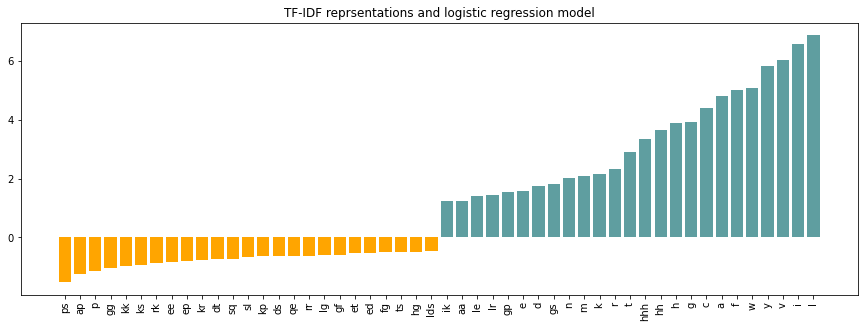

In [69]:
visualize_coefficients('TF-IDF reprsentations and logistic regression model', model1, feature_names)

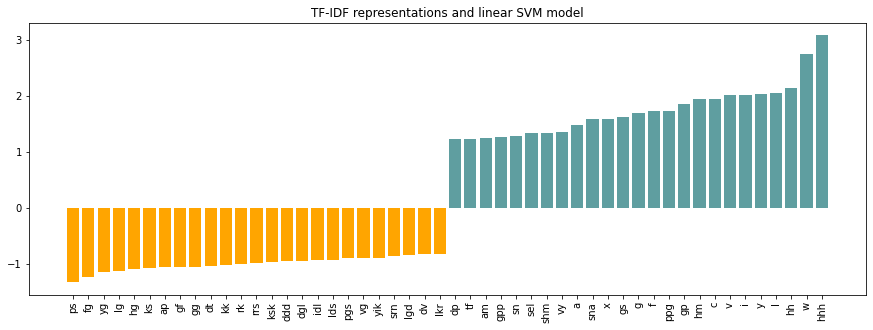

In [70]:
visualize_coefficients('TF-IDF representations and linear SVM model', model2, feature_names)

Model k nearest neighbors does not have an explicit form, that is, it is not determined by some coefficients, so we cannot get to the most relevant words in this way.

## Comparing the classification accuracy of all 6 models

<img src="assets/comparing_models.png" width=750 align="left">